In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
img_size = 1 # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в нашей картинке
batch_size = 16 # размер батча
img_shape = (channels, img_size, img_size) # полный шейп нашей картинки

In [4]:
def our_funk(x):
    return np.sin(x)/x - x/10

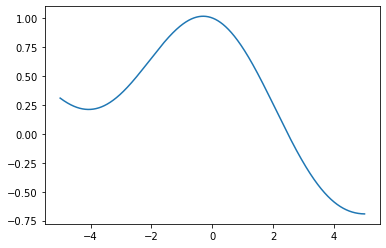

In [5]:
x = np.linspace(-5, 5, 10000)
y = our_funk(x)

plt.plot(x, y)
plt.show()

In [6]:
train_data = torch.tensor(list(zip(x, y)))

In [7]:
train_data.size()

torch.Size([10000, 2])

In [8]:
img_size = 1 # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в нашей картинке
batch_size = 16 # размер батча
img_shape = (channels, img_size, img_size) # полный шейп нашей картинки


real_data = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

In [9]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

### 2. Создание модели

#### 2.1 Генератор:

Генератор G предназначен для отображения вектора скрытого пространства (z) в пространство данных. Поскольку наши данные являются изображениями, преобразование z в пространство данных в конечном итоге означает создание изображения того же размера, что и обучающие изображения (то есть 1x28x28).

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 64, normalize=False), # Звездочка означает unpacking списка
            *block(64, 128),
            nn.Linear(128, 2),
            nn.Tanh()
        )
       

    def forward(self, z):
        img = self.model(z)
        return img

#### 2.2 Дискриминатор:

Как уже упоминалось, дискриминатор D представляет собой сеть двоичной классификации, который принимает изображение в качестве входных данных и выводит скалярную вероятность того, что входное изображение является реальным (в отличие от фальшивого). 

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(128, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# 3. Обучение

Инициализация:

In [12]:
n_epochs = 500 # количество эпох
lr = 0.0005 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 25 # количество картинок для отображения процесса обучения

In [13]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [14]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

[Epoch 499/500] [Batch 600/625] [D loss: 0.190178] [G loss: 2.184685]


<Figure size 432x288 with 0 Axes>

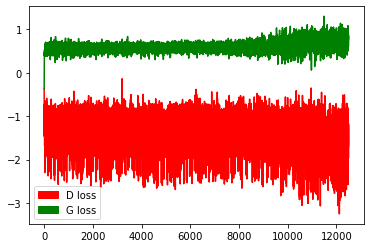

In [15]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
#         print(valid.size())
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = data.type(torch.FloatTensor).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
#         print('z', z.size())
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
#         print('gen_imgs', gen_imgs.size())
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
#         print('real_pred', real_pred.size())
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())
                
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()

                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

In [18]:
z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
gen_data = generator(z)
gen_data = gen_data.detach()
gen_data = gen_data.cpu().numpy()

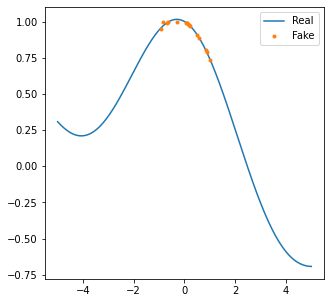

In [19]:
fig = plt.figure(figsize=(5, 5))

plt.plot(train_data[:, 0], train_data[:, 1], label='Real')
plt.plot(gen_data[:, 0], gen_data[:, 1], '.',  label='Fake')
plt.legend(loc='best')
plt.show()